<a href="https://colab.research.google.com/github/ummadiviany/Pix2Pix/blob/main/pix2pix_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PixPi2x Evalutaion Notebook
This notebook is a part of Pix2Pix implementation.

## Importing Libraries
Very straight forward importing all the necessary libraries at one time

In [1]:
!pip install -q albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.1 MB/s 
     |████████████████████████████████| 948 kB 46.8 MB/s 


In [3]:
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, Dataset
    import tqdm as tqdm
    from torchvision.utils import save_image, make_grid
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    import os
    import numpy as np
    from PIL import Image 
    from torchvision import datasets
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    print("Successfully imported all libraries")
except:
    print("Errors in importing libraries")

Successfully imported all libraries


## Downloading pre-trained models & sample testing images 

In [4]:
!git clone https://github.com/ummadiviany/Pix2Pix
from Pix2Pix.training_notebooks.generator_model import Generator
!gdown --id 1W1UQnrlMxqARdbdiO7O-varDZ-vKvQem

Cloning into 'Pix2Pix'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 55 (delta 6), reused 12 (delta 4), pack-reused 0
Unpacking objects: 100% (55/55), done.


## Dataset class

In [8]:
class MapDataset(Dataset):
    def __init__(self,root_dir,input_size):
        self.root_dir = root_dir
        self.input_size = input_size
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self,index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:,:self.input_size,:]
        target_image = image[:,self.input_size:,:]
        
        both_transform= A.Compose(
            [   
                A.Resize(width=256,height=256),
                A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],max_pixel_value=255.0),
                ToTensorV2()
            ]
        )
        input_image =  both_transform(image = input_image)['image']
        target_image = both_transform(image = target_image)['image']

        return input_image, target_image

## Setting testing images directory, Input size  -- **!!Attention Needed!!**
* Change the test images direcory **IMG_DIR** and **INPUT_SIZE** to one of the following options

    1.   ``` "IMG_DIR = test_images/maps"   and INPUT_SIZE = 600 ```
    2.   ``` IMG_DIR = test_images/anime"  and INPUT_SIZE = 512 ```






In [9]:
IMG_DIR = "/content/Pix2Pix/test_images/maps"
INPUT_SIZE = 600
BATCH_SIZE = 4

In [10]:
# Dataset and datalodaer creation
train_dataset = MapDataset(root_dir= IMG_DIR,input_size=INPUT_SIZE)
train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE,shuffle=True)

In [11]:
# drawing one batch of images
input_images, target_images = next(iter(train_loader))

## Model setup -- **!!Attention Needed!!**


*   Change the path of the model to one of the following options


    1.   For testing on Maps dataset ---> model_path = 'Pix2Pix/models/gen_maps.pth.tar'
    2.   For testing on Anime dataset ---> model_path = 'Pix2Pix/models/gen_anime.pth.tar'





In [13]:
def get_model_for_eval(model_path):
  gen = Generator()
  model = torch.load(model_path,map_location=torch.device('cpu'))
  model_state = model['state_dict']
  gen.load_state_dict(model_state)
  return gen.eval()

model_path = 'gen_maps.pth.tar'
gen = get_model_for_eval(model_path)

In [14]:
preds = gen(input_images)

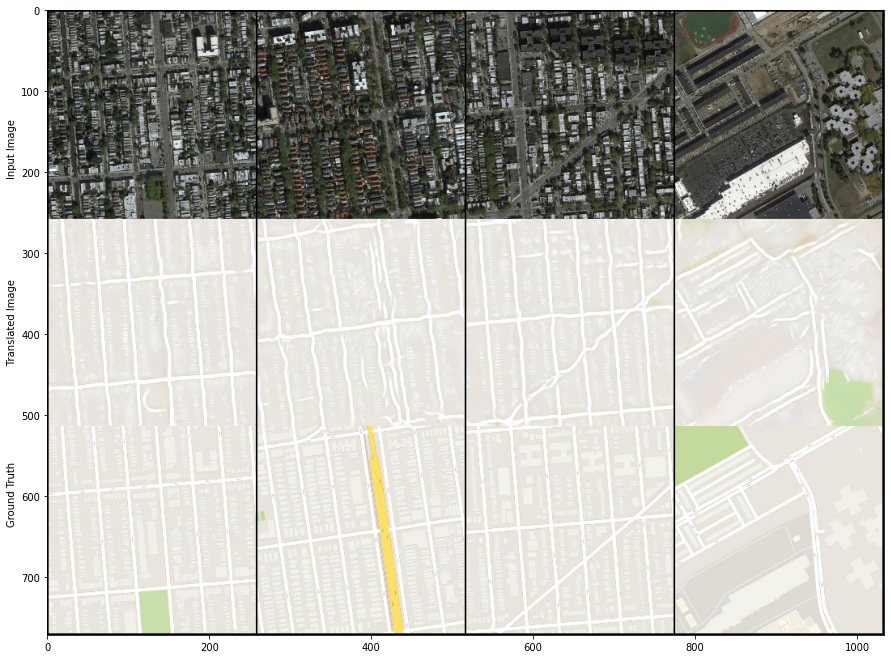

In [15]:
with torch.no_grad():
    res = torch.cat([input_images * 0.5 + 0.5,preds*0.5 + 0.5,target_images * 0.5 + 0.5,],dim=2)
    grid_img = make_grid(res)
    plt.figure(figsize=(15, 20))
    plt.ylabel('Ground Truth                               Translated Image                                Input Image')
    plt.imshow(grid_img.permute(1, 2, 0))